<a href="https://colab.research.google.com/github/jhdown33/Predict-Students-Dropout-and-Academic-Success/blob/main/Academic_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd


df = pd.read_csv('students_academic_success.csv',low_memory=False)

Saving students_academic_success.csv to students_academic_success.csv


In [ ]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pickle
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE


In [ ]:
#Take a look at our data
df.shape

(4424, 37)

In [ ]:
df.head(5)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [ ]:
df.dtypes

,0
Marital Status,int64
Application mode,int64
Application order,int64
Course,int64
Daytime/evening attendance,int64
Previous qualification,int64
Previous qualification (grade),float64
Nacionality,int64
Mother's qualification,int64
Father's qualification,int64


In [ ]:
df['target'].value_counts()

,count
target,
Graduate,2209
Dropout,1421
Enrolled,794


In [ ]:
# Target Categories as percentages
df['target'].value_counts(normalize=True)

,proportion
target,
Graduate,0.499322
Dropout,0.321203
Enrolled,0.179476


In [ ]:
#Encode since target variable is object dtype
le = LabelEncoder()
y_encoded = le.fit_transform(df['target'])

In [ ]:
#5 Define Target Variables
y = y_encoded

X = df.drop(['target'], axis=1)

In [ ]:
#6 Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=0)

In [ ]:
#A will be Random Forest #B will be XGB
#7A use smote to generate new enrolled examples and balance classes
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
#8-A use RFC for class_weight parameter
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced',random_state=0)

In [ ]:
#9-A RFC Define my parameters for tuning use cv params as my  representive variable
cv_params = {'max_depth': [10,20],
              'n_estimators': [100,200], 'max_features': ['sqrt','log2'],
             } # remove for cv, 'colsample_bytree': [0.7]} # remove for cv 'learning_rate': [0.1, 0.2, 0.3], 'min_child_weight': [3,5], 'subsample': [0.8]

In [ ]:
# 10 BOTH Define how my models will be evaluate using my criteria as score
scoring = {    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro',
    'precision_macro': 'precision_macro'}

In [ ]:
#11A
#Grid search for RFC
clf_cv = GridSearchCV(clf, cv_params, scoring= scoring, cv=5, refit = 'f1_macro')

In [ ]:
#12A
# FIT MODEL FOR RFC
clf_cv.fit(X_train_res, y_train_res)
clf_cv

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': 'precision_macro',
                      'recall_macro': 'recall_macro'})

In [ ]:
#13A RFC CV Gridserach for optimal parameters
clf_cv.best_params_

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}

In [ ]:
#14A Results and Eval use optimal parameters
clf_opt = RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=200, random_state=0)

In [ ]:
#15A Fit the RFC optimal model
clf_opt.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=200,
                       random_state=0)

In [ ]:
#16A Run PREDICTION FOR RFC
y_preds = clf_opt.predict(X_test)

In [ ]:
#17A obtain clf scores
pc_clf = metrics.precision_score(y_test, y_preds, average='weighted')
print('Precision Score: ', pc_clf)
ac_clf = metrics.accuracy_score(y_test, y_preds)
print('Accuracy Score: ', ac_clf)

Precision Score:  0.7732921344858347
Accuracy Score:  0.768361581920904


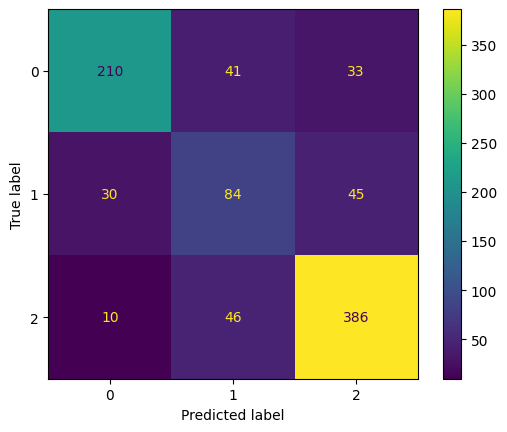

In [ ]:
#18A Show models true and false positives and negatives
cm = metrics.confusion_matrix(y_test, y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_cv.classes_)
disp.plot()

In [ ]:
#8B XGB Instantiate the XBG [Model Building]
XGB = XGBClassifier(random_state=0)

In [ ]:
#9B XGB Define parameters for XGB
cv_params = {'max_depth': [10,20],
              'n_estimators': [100,200], 'max_features': ['sqrt','log2'],
             'colsample_bytree': [0.7], 'learning_rate': [0.1, 0.2, 0.3], 'min_child_weight': [3,5], 'subsample': [0.8]}

In [ ]:
#11B XGB Construct the le GridSearch
XGB_CV = GridSearchCV(XGB, cv_params, scoring= scoring, cv=5, refit = 'f1_macro')

In [ ]:
#12B XGB FIT MODEL TO TRAINING
%%time
XGB_CV.fit(X_train_res, y_train_res)
XGB_CV

CPU times: user 27.9 s, sys: 220 ms, total: 28.1 s
Wall time: 19.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [3, 5],
                         'min_child_weight': [3, 5], 'n_estimators': [10, 15],
                         'subsample': [0.8]},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': 'precision_macro',
                      'recall_macro': 'recall_macro'})

In [ ]:
#13B 4 EVAL & RESULT
y_pred = XGB_CV.predict(X_test)

In [ ]:
#14B XGB GET PREDICTION METRICS
ac_sc = metrics.accuracy_score(y_test, y_pred)
print('Accuracy Score: ', ac_sc)
pc_sc = metrics.precision_score(y_test, y_pred, average='weighted')
print('Precision Score: ', pc_sc)
f1_sc = metrics.f1_score(y_test, y_pred, average='weighted')
print('F1 Score: ', f1_sc)
rc_sc = metrics.recall_score(y_test, y_pred, average='weighted')
print('Recall Score: ', rc_sc)







Accuracy Score:  0.7762711864406779
Precision Score:  0.7907898304771083
F1 Score:  0.7804393230024982
Recall Score:  0.7762711864406779


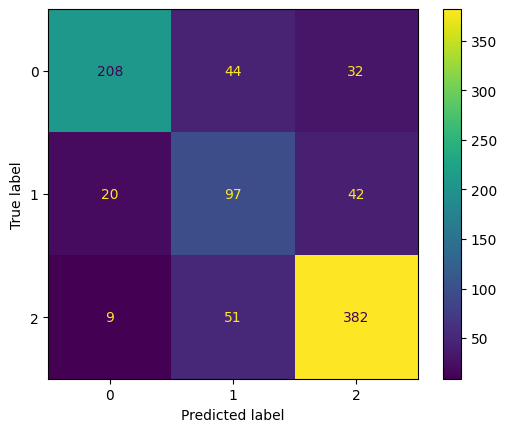

In [ ]:
#15B XGB PLOT CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=XGB_CV.classes_)
disp.plot()

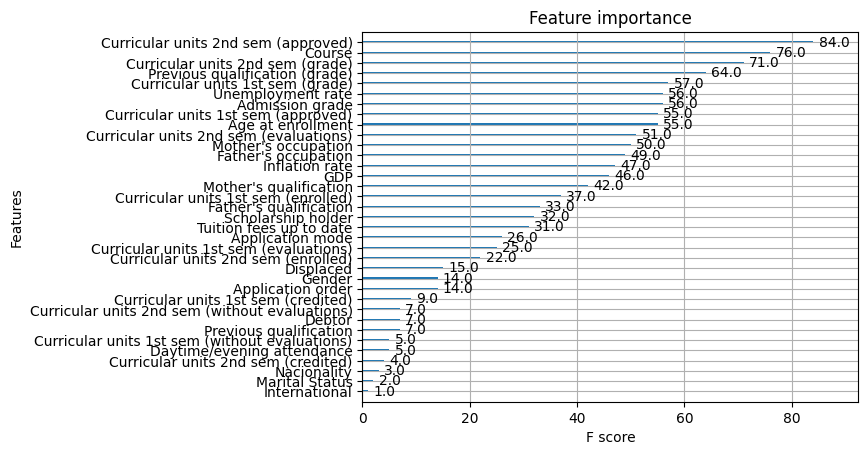

In [ ]:
#16B ONLY XGB  Visualize most important features
plot_importance(XGB_CV.best_estimator_)
plt.show()

In [ ]:
#17B create table to show my results
table = pd.DataFrame(XGB_CV.cv_results_)
table.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,...,std_test_recall_macro,rank_test_recall_macro,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro
0,0.210226,0.154316,0.040943,0.010781,0.7,0.1,3,3,10,0.8,...,0.011767,23,0.676027,0.647944,0.634917,0.689696,0.668703,0.663457,0.019643,23
1,0.251672,0.159236,0.046278,0.012741,0.7,0.1,3,3,15,0.8,...,0.011517,22,0.686020,0.656365,0.642967,0.689021,0.667892,0.668453,0.017479,22
2,0.058059,0.009351,0.026324,0.001871,0.7,0.1,3,5,10,0.8,...,0.011085,24,0.671924,0.660165,0.633951,0.689696,0.658559,0.662859,0.018242,24
3,0.062614,0.003119,0.025311,0.000477,0.7,0.1,3,5,15,0.8,...,0.010173,21,0.683160,0.664206,0.645216,0.689708,0.672170,0.670892,0.015557,21
4,0.071304,0.011269,0.025578,0.001054,0.7,0.1,5,3,10,0.8,...,0.012946,15,0.702772,0.683913,0.667225,0.688782,0.739158,0.696370,0.024224,13
